In [ ]:
# importação de bibliotecas:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone

In [ ]:
# importação do dataset de diabetes:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
colunas = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
           'Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']

df = pd.read_csv(url, names=colunas)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# tratamento de dados

# Tratar zeros como NaN
variaveis_com_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[variaveis_com_zero] = df[variaveis_com_zero].replace(0, np.nan)

# Substituir NaN pela média
df.fillna(df.mean(), inplace=True)

# Separar atributos e rótulo
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [ ]:
# modelo
# Criar pipeline SVM + padronização
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Definição da grade de hiperparâmetros
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 0.01, 0.001]
}

Melhores parâmetros (KFold-10): {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Acurácia média (KFold-10): 0.7655673274094327


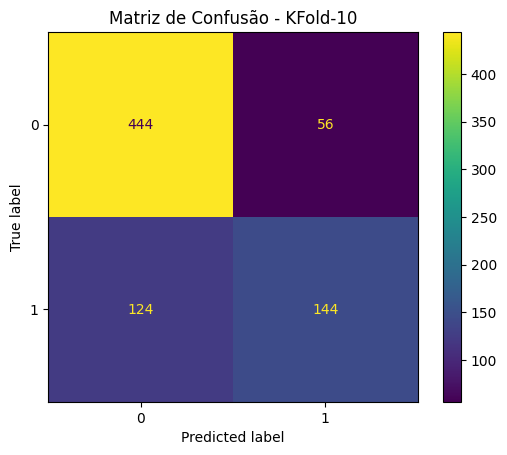

In [ ]:
# KFold-10
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

grid_kfold = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy')
grid_kfold.fit(X, y)

print("Melhores parâmetros (KFold-10):", grid_kfold.best_params_)
print("Acurácia média (KFold-10):", grid_kfold.best_score_)

# Matriz de confusão usando cross_val_predict
from sklearn.model_selection import cross_val_predict
y_pred_kfold = cross_val_predict(grid_kfold.best_estimator_, X, y, cv=kfold)
cm_kfold = confusion_matrix(y, y_pred_kfold)

ConfusionMatrixDisplay(cm_kfold).plot()
plt.title("Matriz de Confusão - KFold-10")
plt.show()

Acurácia média (ShuffleSplit): 0.7740 ± 0.0260
Matriz de Confusão média:
 [[133.8  18.6]
 [ 33.6  45. ]]


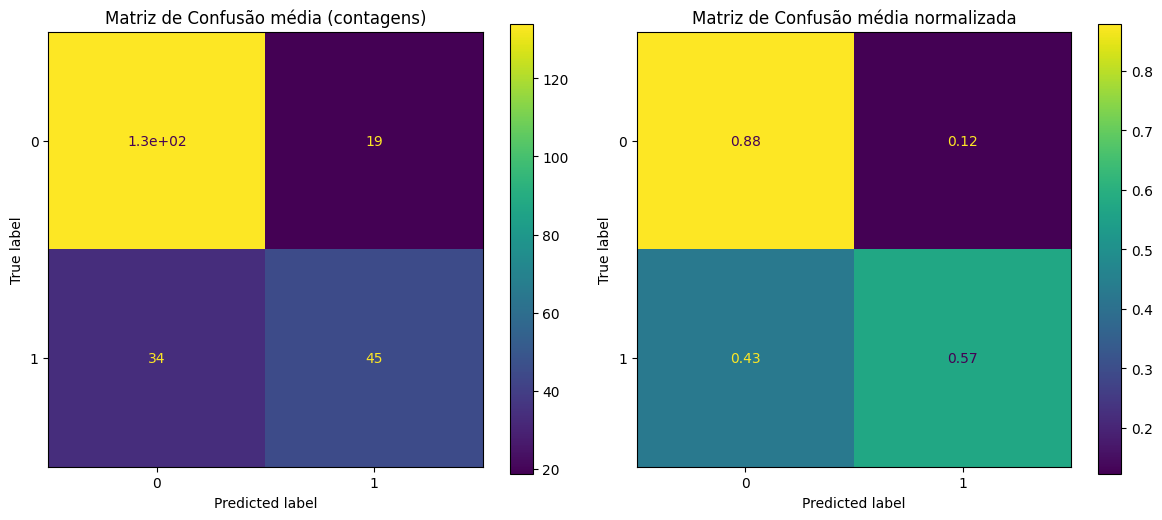

In [ ]:
# ShuffleSplit 30% teste, 10 splits
shuffle = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

n_splits = shuffle.get_n_splits(X, y)
cm_sum = np.zeros((2,2), dtype=float)
accs = []

for train_idx, test_idx in shuffle.split(X, y):
    est = clone(grid_shuffle.best_estimator_) if 'grid_shuffle' in locals() else clone(grid_kfold.best_estimator_)
    est.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = est.predict(X.iloc[test_idx])
    y_true = y.iloc[test_idx]

    accs.append(accuracy_score(y_true, y_pred))
    cm_sum += confusion_matrix(y_true, y_pred, labels=[0,1])

# Média das métricas
acc_mean = np.mean(accs)
acc_std = np.std(accs)
cm_avg = cm_sum / n_splits

print(f"Acurácia média (ShuffleSplit): {acc_mean:.4f} ± {acc_std:.4f}")
print("Matriz de Confusão média:\n", np.round(cm_avg, 2))

# Plot
fig, axs = plt.subplots(1,2, figsize=(12,5))

# Matriz média (contagens)
ConfusionMatrixDisplay(cm_avg, display_labels=[0,1]).plot(ax=axs[0])
axs[0].set_title('Matriz de Confusão média (contagens)')

# Normalizada por linha
row_sums = cm_avg.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_avg, row_sums, where=(row_sums!=0))
ConfusionMatrixDisplay(cm_norm, display_labels=[0,1]).plot(ax=axs[1])
axs[1].set_title('Matriz de Confusão média normalizada')

plt.tight_layout()
plt.show()

In [ ]:
print("Resumo Comparativo:")
print(f"KFold-10: acurácia média = {grid_kfold.best_score_:.4f}")
print(f"ShuffleSplit: acurácia média = {acc_mean:.4f} ± {acc_std:.4f}")

print("\nDiscussão:")
print("Se as acurácias são próximas, o modelo é estável frente a diferentes estratégias de validação.")
print("Diferenças podem indicar sensibilidade à forma como os dados são divididos.")

Resumo Comparativo:
KFold-10: acurácia média = 0.7656
ShuffleSplit: acurácia média = 0.7740 ± 0.0260

Discussão:
Se as acurácias são próximas, o modelo é estável frente a diferentes estratégias de validação.
Diferenças podem indicar sensibilidade à forma como os dados são divididos.
